In [119]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin,pi,exp
from matplotlib import cm
from scipy.linalg import solve
from datetime import datetime
from scipy.linalg import lu_factor, lu_solve, lstsq
from scipy.linalg import cho_factor, cho_solve

In [120]:
# les paramétre :

p = 15
n = (p+1)*3/2 -1
n = 23
q = (p+1) * 3/4 -1
q = 11
m = 10
Longeur = 6
Hauteur = 4
dx = Longeur/(n+1)
dy = Hauteur/(m+1)

x= np.linspace(0,Longeur,n+2)
y= np.linspace(0,Hauteur,m+2)

x1 = np.linspace(0,4,p+2)
x2 = np.linspace(3,6,q+2)

X, Y = np.meshgrid(x,y)
X1, Y1 = np.meshgrid(x1,y)
X2, Y2 = np.meshgrid(x2,y)


### Def des matrice $M_u$ $M_v$, $R$, et $S$. les vecteur $G$, $H$ et les fonction $b_u(g)$ et $b_v(h)$

In [121]:
# def des matrix
def mat_Mu_Mv(p,q,m,dx,dy):
    ID_p = np.eye(p)
    ID_q = np.eye(q)
    Ap = -2*np.eye(p)+np.eye(p,k=1)+np.eye(p,k=-1)
    Aq = -2*np.eye(q)+np.eye(q,k=1)+np.eye(q,k=-1)
    Am = -2*np.eye(m)+np.eye(m,k=1)+np.eye(m,k=-1)
    Mu = 1/(dx**2) * np.kron(np.eye(m),Ap) + 1/(dy**2) * np.kron(Am,ID_p)
    Mv = 1/(dx**2) * np.kron(np.eye(m),Aq) + 1/(dy**2) * np.kron(Am,ID_q)
    return Mu, Mv

Mu, Mv= mat_Mu_Mv(p,q,m,dx,dy)
Mu_fact = lu_factor(Mu)
Mv_fact = lu_factor(Mv)

# les fonctions au frontière g et h
def g(y) :
    xx = 4
    return u(xx,y)
def h(y) :
    xx = 3
    return u(xx,y)

# définition de G et H
def G(gg,p,q,m) : 
    Gv = np.zeros(p*m)
    for i in range(1,p*m+1):
        if (i%p ) == 0 :
            Gv[i-1] = gg[i//p - 1 ]
    return Gv/dx**2
def H(hh,p,q,m) : 
    Hv = np.zeros(q*m)
    for i in range(1,q*m+1):
        if ((i-1)%q ) == 0 :
            Hv[i-1] = hh[(i-1)//q ]
    return Hv/dx**2

# definition de bu(g) et bv(h)
def bu(g,p,q,m,fu) :
    return fu - G(g,p,q,m)
def bv(h,p,q,m,fv) : 
    return fv - H(h,p,q,m)


# def des matrices R et S
def mat_R_S(p,q,n):
    p_q_n = p + q - n  # Nombre de lignes de aux1
    n_q = n - q        # Nombre de colonnes de aux1
    aux1 = np.zeros((p_q_n, n_q))
    ID_pqn = np.eye(p_q_n)
    R_overline = np.block([
        [aux1, ID_pqn]
    ])
    R = np.kron(np.eye(m),R_overline)
    p_q_n = p + q - n  # Nombre de lignes de aux1
    n_p = n - p        # Nombre de colonnes de aux1
    aux2 = np.zeros((p_q_n, n_p))
    ID_pqn = np.eye(p_q_n)
    S_overline = np.block([
        [ID_pqn, aux2]
    ])
    S = np.kron(np.eye(m),S_overline)
    return R,S

R, S = mat_R_S(p,q,n)

### Définir la solution écacte et la seconde membre pour la virification 

In [124]:
# vérification pour les matrices
# la fonction de solution exacte 
def u(x,y) : 
    return x*(6-x)*y*(4-y)
# la seconde membre f
def f(x,y) :
    return -2*(x*(6-x)+y*(4-y))

Xu, Yu = np.meshgrid(x1[1:-1], y[1:-1])
Xv, Yv = np.meshgrid(x2[1:-1], y[1:-1])
Fu = f(Xu,Yu)
Fv = f(Xv,Yv)
fu = Fu.ravel(order='C')
fv = Fv.ravel(order='C')
Fu_reconstructed = fu.reshape(Fu.shape, order='C')
Fv_reconstructed = fv.reshape(Fv.shape, order='C')


bug = bu(g(y)[1:-1],p,q,m,fu)
bvh = bv(h(y)[1:-1],p,q,m,fv)

U_exacte = u(Xu,Yu).ravel(order='C')
U_approx = solve(Mu,bug)

# Différence entre les deux vecteurs
difference = U_exacte - U_approx

# Calcul de la norme L2
dV = dx * dy  # Surface élémentaire
norm_L2 = np.sqrt(np.sum(difference**2) * dV)
norm_u = np.sqrt(np.sum(U_exacte**2) * dV)

print(f"Erreur relative norme L2 : {norm_L2/norm_u}")

Erreur relative norme L2 : 3.440980912316761e-16


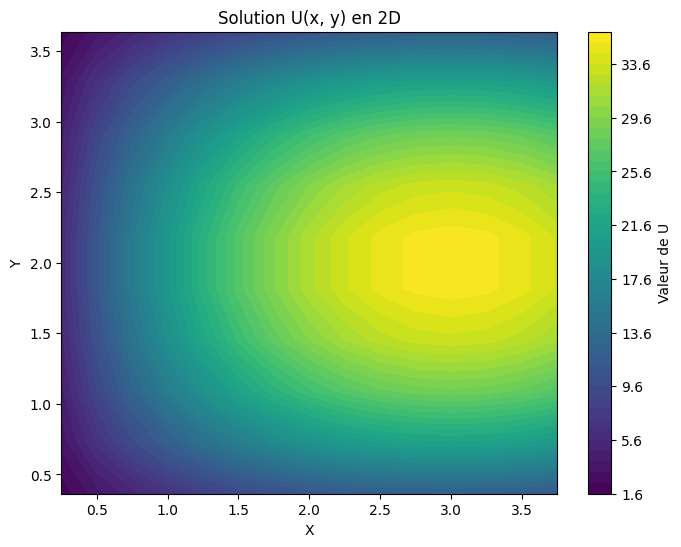

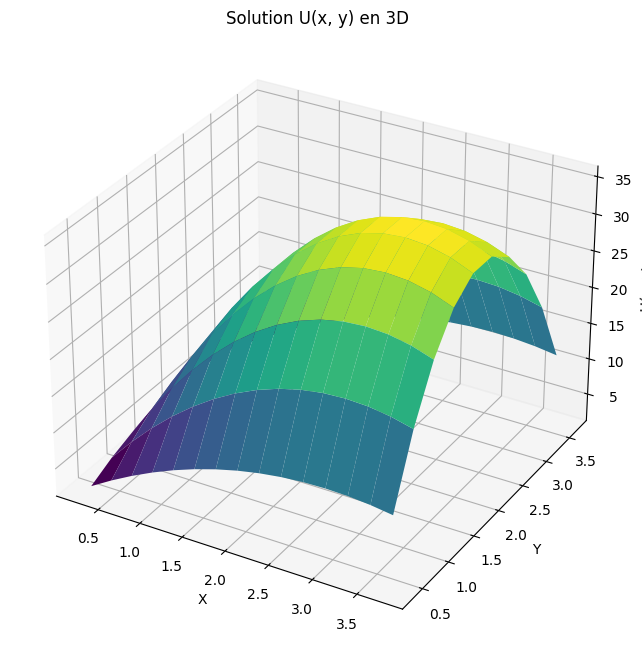

In [125]:
# Tracé en 2D avec une carte de couleurs
plt.figure(figsize=(8, 6))
plt.contourf(Xu, Yu, U_exacte.reshape(u(Xu,Yu).shape, order='C'), levels=50, cmap='viridis')  # Carte de couleurs
plt.colorbar(label='Valeur de U')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Solution U(x, y) en 2D')
plt.show()

# Tracé en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xu, Yu, U_exacte.reshape(u(Xu,Yu).shape, order='C'), cmap='viridis', edgecolor='none')  # Surface en 3D
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U(x, y)')
ax.set_title('Solution U(x, y) en 3D')
plt.show()

# 1) La méthode de sensibilité

## Définition des matrice et vecteur nécessaire

In [126]:
# méthode de sensibilité 
# je définie les vecteurs canoniques e_p et e_q de taille p*m et q*m

def ep(i,p,q,m) :  # pour i de 1 à m
    sol = np.zeros(p*m)
    sol[i*p-1] = 1
    return sol         # remarque, je peux faire d'autre truc, solve(Mu,ep/dx^2)

def eq(i,p,q,m) :              # pour i de 1 à m
    sol = np.zeros(q*m)
    sol[(i-1)*q] = 1
    return sol
# def matrice pour calculer le gradient 
def mat_Muep(m,Mu_inv,p,q):
    sol = np.zeros((m,p*m))
    for i in range(m):
        sol[i,:] = Mu_inv@ep(i+1,p,q,m)
    return -sol/dx**2
def mat_Mveq(m,Mv_inv,p,q):
    sol = np.zeros((m,q*m))
    for i in range(m):
        sol[i,:] = Mv_inv@eq(i+1,p,q,m)
    return sol/dx**2



## Initialisation... la choix de $g^0$ et $h^0$ au hasard

In [132]:

g_initial = np.random.rand(m)
h_initial = np.random.rand(m)

## Algorithme de la sensibilité

In [133]:
# algorithme de sensibilité
# première étape : la choix de g0 et h0
Mu_inv = np.linalg.inv(Mu)
Mv_inv = np.linalg.inv(Mv)

g0 = g_initial
h0 = h_initial

# 2-ème étape, calculons U^n et V^n 
Un = lu_solve(Mu_fact,bu(g0,p,q,m,fu))
Vn = lu_solve(Mv_fact,bv(h0,p,q,m,fv))
Muep=mat_Muep(m,Mu_inv,p,q)
Mveq=mat_Mveq(m,Mv_inv,p,q)

# 3-ème étape, calcule de gradients
Gu = dx*dy*Muep@R.T@(R@Un-S@Vn)
Gv = dx*dy*Mveq@S.T@(R@Un-S@Vn)

iter=0
eps = 10**(-3)
mu = 0.5
rh = 0.5
t1 = datetime.now()

while (np.linalg.norm(Gu) + np.linalg.norm(Gv) > eps ) :
    g0 = g0 - mu*Gu
    h0 = h0 - rh*Gv
    Un = lu_solve(Mu_fact,bu(g0,p,q,m,fu))
    Vn = lu_solve(Mv_fact,bv(h0,p,q,m,fv))
    Gu = dx*dy*Muep@R.T@(R@Un-S@Vn)
    Gv = dx*dy*Mveq@S.T@(R@Un-S@Vn)
    if iter == 5 :
        test_grad_sensabilite = Gu
    iter=iter+1
t2 = datetime.now()
delta = t2-t1
print(f"valeur d'intégrale = {np.matmul((np.matmul(R,Un)-np.matmul(S,Vn)).T,(np.matmul(R,Un)-np.matmul(S,Vn)))/2 *dx*dy}")
print(f"numbre d'iteration = {iter}")
print("En secondes :", delta.total_seconds())

valeur d'intégrale = 3.7325990599409364e-05
numbre d'iteration = 2093
En secondes : 0.223251


### définition la fonction de sensibilité pour l'autilise dans l'étude de convergence à la fin de ce fichier

In [134]:
def sensibilite(p,q,m,n,g_initial,h_initial,Mu,Mv,eps,test_n):
    # première étape : la choix de g0 et h0
    Mu_inv = np.linalg.inv(Mu)
    Mv_inv = np.linalg.inv(Mv)

    g0 = np.copy(g_initial)
    h0 = np.copy(h_initial)

    # 2-ème étape, calculons U^n et V^n 
    Un = lu_solve(Mu_fact,bu(g0,p,q,m,fu))
    Vn = lu_solve(Mv_fact,bv(h0,p,q,m,fv))
    Muep=mat_Muep(m,Mu_inv,p,q)
    Mveq=mat_Mveq(m,Mv_inv,p,q)
    
    # 3-ème étape, calcule de gradients
    Gu = dx*dy*Muep@R.T@(R@Un-S@Vn)
    Gv = dx*dy*Mveq@S.T@(R@Un-S@Vn)
    
    iter=0
    
    mu = 0.5
    rh = 0.5
    t1 = datetime.now()
    while (np.linalg.norm(Gu) + np.linalg.norm(Gv) > eps ) :
        g0 = g0 - mu*Gu
        h0 = h0 - rh*Gv
        Un = lu_solve(Mu_fact,bu(g0,p,q,m,fu))
        Vn = lu_solve(Mv_fact,bv(h0,p,q,m,fv))
        Gu = dx*dy*Muep@R.T@(R@Un-S@Vn)
        Gv = dx*dy*Mveq@S.T@(R@Un-S@Vn)
        if iter == test_n :
            test_grad_sensabilite = Gu
        iter=iter+1
    t2 = datetime.now()
    delta = t2-t1
    integral = np.matmul((np.matmul(R,Un)-np.matmul(S,Vn)).T,(np.matmul(R,Un)-np.matmul(S,Vn)))/2 *dx*dy
    err = np.sqrt(np.sum((u(Xu,Yu).ravel(order='C')-Un)**2) * dx*dy)
    norm_u = np.sqrt(np.sum(u(Xu,Yu).ravel(order='C')**2) * dV)

    return integral, err/norm_u, iter, delta.total_seconds(),test_grad_sensabilite

In [135]:
# reshape les solution approchée puis, ajouter les conditions aux bords

U_minn = Un.reshape(u(Xu,Yu).shape, order='C')
V_minn = Vn.reshape(u(Xv,Yv).shape, order='C')
U_min = np.zeros(u(X1,Y1).shape)
V_min = np.zeros(u(X2,Y2).shape)
U_min[1:-1,1:-1] = U_minn
V_min[1:-1,1:-1] = V_minn
U_min[1:-1, -1] = g0
V_min[1:-1,0] = h0

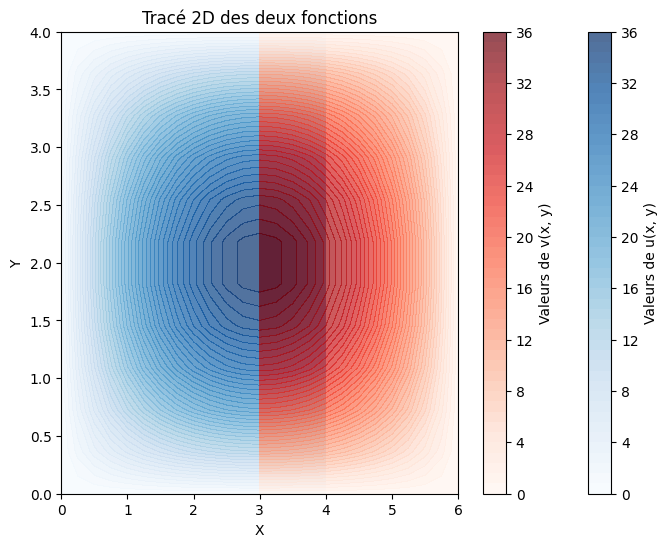

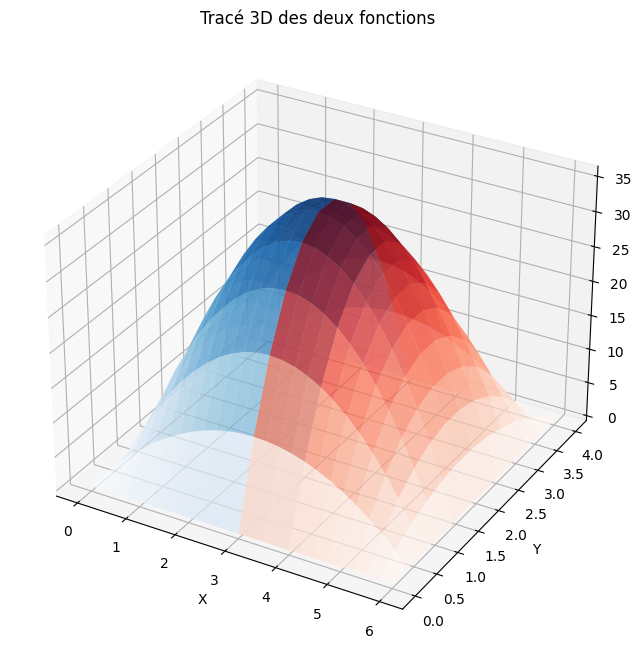

In [136]:
# Tracé en 2D
plt.figure(figsize=(8, 6))
contour1 = plt.contourf(X1, Y1, U_min, levels=50, cmap='Blues', alpha=0.7)
contour2 = plt.contourf(X2, Y2, V_min, levels=50, cmap='Reds', alpha=0.7)
plt.colorbar(contour1, label='Valeurs de u(x, y)')
plt.colorbar(contour2, label='Valeurs de v(x, y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Tracé 2D des deux fonctions')
plt.show()

# Tracé en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, Y1, U_min, cmap='Blues', alpha=0.7, edgecolor='none', label='u(x, y)')
ax.plot_surface(X2, Y2, V_min, cmap='Reds', alpha=0.7, edgecolor='none', label='v(x, y)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Tracé 3D des deux fonctions')
plt.show()

### Trace de la différence u-v dans l'intersection

In [137]:
# un autre graphe qui affiche la différence dans l'intersection 
xdif = np.linspace(3,4,p+q+2-n)
X_diff, Y_diff = np.meshgrid(xdif[1:-1], y[1:-1])
dif_Vecteur = (np.matmul(R,Un) - np.matmul(S,Vn))
dif_2D = dif_Vecteur.reshape(u(X_diff,Y_diff).shape, order='C')




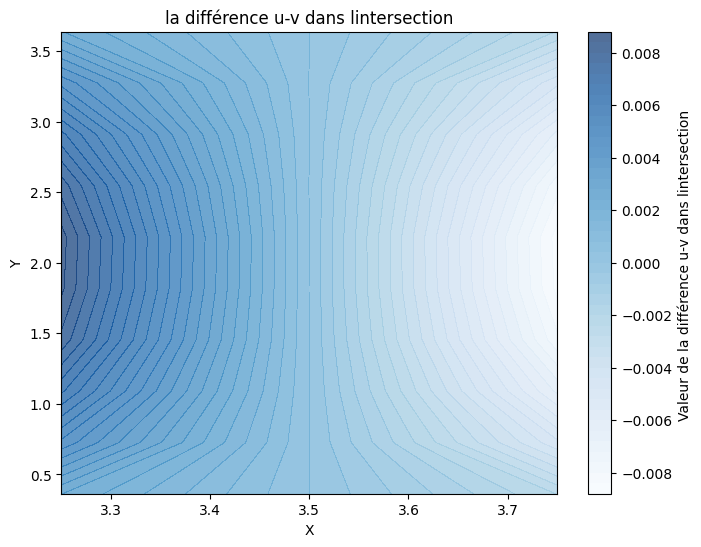

In [138]:
# Tracé en 2D
plt.figure(figsize=(8, 6))
contour1 = plt.contourf(X_diff, Y_diff, dif_2D, levels=50, cmap='Blues', alpha=0.7)
plt.colorbar(contour1, label='Valeur de la différence u-v dans l''intersection ')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('la différence u-v dans l''intersection')
plt.show()


### Calcule de l'érreur de la solution obtenue par la sensibilité et la solution exacte

In [139]:
# vérification si les solutions minimums approche de la sulotion exacte
#.                                 pour l'équation de laplace avec le second membre f
U_exacte = u(X1,Y1).ravel(order='C')
U_approx = U_min.ravel(order='C')

# Différence entre les deux vecteurs
difference = U_exacte - U_approx

# Calcul de la norme L2
dV = dx * dy  # Surface élémentaire
norm_L2 = np.sqrt(np.sum(difference**2) * dV)
norm_u = np.sqrt(np.sum(u(Xu,Yu).ravel(order='C')**2) * dV)

print(f"Erreur relative L2 : {norm_L2/norm_u}")

Erreur relative L2 : 0.00047812222149326447


# 2) Algorithme de l'équation adointe:

### Définition des matrice nécessaire pour l'adjointe

In [106]:
def mat_Mep(p,q,m):
    sol = np.zeros((m,m*p))
    for i in range(m):
        sol[i,:] = ep(i+1,p,q,m)
    return -sol/dx**2
def mat_Meq(p,q,m):
    sol = np.zeros((m,m*q))
    for i in range(m):
        sol[i,:] = eq(i+1,p,q,m)
    return sol/dx**2
def lamm_1(MuTRT,U,V):
    return dx*dy*MuTRT@(R@U-S@V)
def lamm_2(MvTST,U,V):
    return dx*dy*MvTST@(R@U-S@V)

### Algorithme de l'adjointe

In [111]:
# première étape : la choix de g0 et h0
g0 = np.copy(g_initial)
h0 = np.copy(h_initial)
MuT_fact = lu_factor(Mu.T)
MvT_fact = lu_factor(Mv.T)
# 2-ème étape, calculons U^n et V^n 
Un = lu_solve(Mu_fact,bu(g0,p,q,m,fu))
Vn = lu_solve(Mv_fact,bv(h0,p,q,m,fv))

# 3-ème étape, calcule de lambda_1 et lambda_2
MuTRT = Mu_inv.T@R.T
MvTST = Mv_inv.T@S.T
lambda_1 = lamm_1(MuTRT,Un,Vn)
lambda_2 = lamm_2(MvTST,Un,Vn)
# def Grad_bu(g) et Grad_bv(h)
Mep = mat_Mep(p,q,m)
Meq = mat_Meq(p,q,m)

gunn = Mep@lambda_1
gvnn = Meq@lambda_2
iter=0
eps = 10**(-3)
mu = 0.5
rh = 0.5
t1 = datetime.now()
while (np.linalg.norm(gunn) + np.linalg.norm(gvnn) > eps ) :
    g0 = g0 - mu*gunn
    h0 = h0 - rh*gvnn
    Un = lu_solve(Mu_fact,bu(g0,p,q,m,fu))
    Vn = lu_solve(Mv_fact,bv(h0,p,q,m,fv))
    lambda_1 = lamm_1(MuTRT,Un,Vn)
    lambda_2 = lamm_2(MvTST,Un,Vn)
    gunn = Mep@lambda_1
    gvnn = Meq@lambda_2
    if iter == 5 :
        test_grad_adjoint = gunn
    iter = iter +1
t2 = datetime.now()
delta = t2-t1
print(f"valeur d'intégral = {np.matmul((np.matmul(R,Un)-np.matmul(S,Vn)).T,(np.matmul(R,Un)-np.matmul(S,Vn)))/2 *dx*dy}")
print(f"numbre d'iteration = {iter}")
print("En secondes :", delta.total_seconds())

valeur d'intégral = 3.740656203324486e-05
numbre d'iteration = 2092
En secondes : 0.271337


### Definition de la fonction adjointe pour l'utiliser dans les tests d'étude de convergence plus tard

In [140]:
def adjointe(p,q,m,n,g_initial,h_initial,Mu,Mv,eps,test_n):
    # première étape : la choix de g0 et h0
    g0 = np.copy(g_initial)
    h0 = np.copy(h_initial)
    MuT_fact = lu_factor(Mu.T)
    MvT_fact = lu_factor(Mv.T)
    # 2-ème étape, calculons U^n et V^n 
    Un = lu_solve(Mu_fact,bu(g0,p,q,m,fu))
    Vn = lu_solve(Mv_fact,bv(h0,p,q,m,fv))
    
    # 3-ème étape, calcule de lambda_1 et lambda_2
    MuTRT = Mu_inv.T@R.T
    MvTST = Mv_inv.T@S.T
    lambda_1 = lamm_1(MuTRT,Un,Vn)
    lambda_2 = lamm_2(MvTST,Un,Vn)
    # def Grad_bu(g) et Grad_bv(h)
    Mep = mat_Mep(p,q,m)
    Meq = mat_Meq(p,q,m)
    
    gunn = Mep@lambda_1
    gvnn = Meq@lambda_2
    iter=0
    mu = 0.5
    rh = 0.5
    t1 = datetime.now()
    while (np.linalg.norm(gunn) + np.linalg.norm(gvnn) > eps ) :
        g0 = g0 - mu*gunn
        h0 = h0 - rh*gvnn
        Un = lu_solve(Mu_fact,bu(g0,p,q,m,fu))
        Vn = lu_solve(Mv_fact,bv(h0,p,q,m,fv))
        lambda_1 = lamm_1(MuTRT,Un,Vn)
        lambda_2 = lamm_2(MvTST,Un,Vn)
        gunn = Mep@lambda_1
        gvnn = Meq@lambda_2
        if iter == test_n :
            test_grad_adjoint = gunn
        iter = iter +1
    t2 = datetime.now()
    delta = t2-t1
    integral = np.matmul((np.matmul(R,Un)-np.matmul(S,Vn)).T,(np.matmul(R,Un)-np.matmul(S,Vn)))/2 *dx*dy
    err = np.sqrt(np.sum((u(Xu,Yu).ravel(order='C')-Un)**2) * dx*dy)
    norm_u = np.sqrt(np.sum(u(Xu,Yu).ravel(order='C')**2) * dV)
    
    return integral, err/norm_u, iter, delta.total_seconds(),test_grad_adjoint


###  test pour vérifier que la sensibilité et l'adjointe ont le même gradient pour tous les itération

In [142]:

print( np.max(abs(test_grad_adjoint-test_grad_sensabilite)))

0.030992792045030394


# 3) Méthode de Gradient projeté

### Étape 1 : Choix de $X^0$ dans $V$

On choisit $X^0$ dans l'ensemble :  
$$
V = \left\{ X \in \mathbb{R}^{(p+q) \cdot m + 2m} \mid BX = \begin{pmatrix} F_1 \\ F_2 \end{pmatrix} \right\}.
$$

avec :  
$$
X = \begin{pmatrix} U \\ V \\ g \\ h \end{pmatrix}  
\quad \text{et} \quad  
B = \begin{pmatrix} 
M_u & 0 & \hat{G} & 0 \\ 
0 & M_v & 0 & \hat{H} 
\end{pmatrix}.
$$

### Définition des matrice $A$ et $B$

In [144]:
# on choisit au hasard g0 et h0, puis on calcule U et V 
# correspondante
g0 = np.random.rand(m)
h0 = np.random.rand(m)
Un = solve(Mu,bu(g0,p,q,m,fu))
Vn = solve(Mv,bv(h0,p,q,m,fv))
Xn = np.concatenate([Un, Vn, g0, h0])  # Xn dans l'espace V

# construction des matrices B et A
def mat_A_B(p,q,n,m,dx,dy,Mu,Mv,R,S):
    # 1) construction des matrices hat_G et hat_H
    hat_G = np.zeros((m*p,m))
    hat_H = np.zeros((m*q,m))
    for i in range(m):
        hat_G[(i+1)*p-1,i] = 1
        hat_H[i*q,i] = 1
    hat_G = hat_G/dx**2
    hat_H = hat_H/dx**2
    
    # définition da la matrice B
    B = np.zeros((m*(p+q),m*(p+q+2)))
    B[:m*p,:m*p]=Mu
    B[m*p:,m*p:m*(p+q)]=Mv
    B[:m*p,m*(p+q):m*(p+q+1)]=hat_G
    B[m*p:,m*(p+q+1):] = hat_H
    
    # définition de la matrice A
    A = np.zeros((m*(p+q+2),m*(p+q+2)))
    A[:m*p,:m*p] = np.matmul(R.T,R)
    A[m*p:m*(p+q),m*p:m*(p+q)] = np.matmul(S.T,S)
    A[:m*p,m*p:m*(p+q)] = -np.matmul(R.T,S)
    A[m*p:m*(p+q),:m*p] = -np.matmul(S.T,R)
    A =A*dx*dy/2
    return A,B
A, B = mat_A_B(p,q,n,m,dx,dy,Mu,Mv,R,S)
#A=A+np.eye(m*(p+q+2))/1000000

### étape 2 : calcule de $\lambda^n$
$$ B B^T \lambda^n = B A X^n $$
avec $$ A = \begin{pmatrix} R^TR & -R^TS & 0 & 0 \\ -S^TR & S^TS & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{pmatrix} $$

In [145]:
BBT = np.matmul(B,B.T)
AXn = 2*np.matmul(A,Xn)
BAXn = np.matmul(B,AXn)
lamb_n = solve(BBT,BAXn)


### étape 3 : calcule de gradient projeté $g_p^n$
$$ g_p^n = AX^n - B^T \lambda^n $$

In [146]:
gpn = AXn - np.matmul(B.T,lamb_n)


### étape 4 : test $\| g_p^n \| < \epsilon $

In [147]:
test = np.linalg.norm(gpn)

### algorithme de Gradient projeté avec la factorisation Cholesky et sans (BFGS et Armijo)

In [118]:
# 1
g0 = np.random.rand(m)
h0 = np.random.rand(m)
Un = solve(Mu,bu(g0,p,q,m,fu))
Vn = solve(Mv,bv(h0,p,q,m,fv))
Xn = np.concatenate([Un, Vn, g0, h0])

# 2
BBT = np.matmul(B,B.T)
BBT_fact = cho_factor(BBT)
AXn = 2*np.matmul(A,Xn)
BAXn = np.matmul(B,AXn)
lamb_n = cho_solve(BBT_fact, BAXn)
BT = B.T
#3
gpn = AXn - np.matmul(B.T,lamb_n)

epsi = 10**(-3)
iter = 0
mu = 0.5
t1 = datetime.now()
while np.linalg.norm(gpn)>epsi :
    Xn = Xn - mu* gpn
    AXn = 2*np.matmul(A,Xn)
    BAXn = np.matmul(B,AXn)
    lamb_n = cho_solve(BBT_fact, BAXn)
    gpn = AXn - np.matmul(BT,lamb_n)
    iter = iter +1
t2 = datetime.now()
delta = t2-t1
print(f"valeur d'intégral = {np.matmul(Xn.T,AXn)}")
print(f"numbre d'iteration = {iter}")
print("En secondes :", delta.total_seconds())

valeur d'intégral = 0.0004463831216735643
numbre d'iteration = 5433
En secondes : 2.072496


### algorithme de Gradient projeté avec la factorisation Cholesky et Armijo sans (BFGS)

In [73]:
# Initialisation
g0 = np.random.rand(m)
h0 = np.random.rand(m)
Un = solve(Mu, bu(g0,p,q,m,fu))
Vn = solve(Mv, bv(h0,p,q,m,fv))
Xn = np.concatenate([Un, Vn, g0, h0])

BBT = np.matmul(B, B.T)
BBT_fact = cho_factor(BBT)
AXn = 2 * np.matmul(A, Xn)
BAXn = np.matmul(B, AXn)
lamb_n = cho_solve(BBT_fact, BAXn)
gpn = AXn - np.matmul(B.T, lamb_n)

# Critères d'arrêt et paramètres d'Armijo
epsi = 1e-3
iter = 0
beta = 0.5
sigma = 0.1
t1 = datetime.now()

while np.linalg.norm(gpn) > epsi:
    # Calcul de la direction de descente
    d = -gpn
    
    # Recherche linéaire d'Armijo
    mu = 1.0
    while True:
        X_new = Xn + mu * d
        AX_new = 2 * np.matmul(A, X_new)
        BAX_new = np.matmul(B, AX_new)
        lamb_new = cho_solve(BBT_fact, BAX_new)
        gpn_new = AX_new - np.matmul(B.T, lamb_new)
        
        # Vérification de la condition d'Armijo
        if (np.matmul(X_new.T, AX_new) <= np.matmul(Xn.T, AXn) + sigma * mu * np.dot(gpn, d)):
            break
        mu *= beta
    
    # Mise à jour
    Xn = X_new
    AXn = AX_new
    gpn = gpn_new
    iter += 1

t2 = datetime.now()
delta = t2 - t1

# Résultats
print(f"Valeur d'intégral = {np.matmul(Xn.T, AXn)}")
print(f"Nombre d'itérations = {iter}")
print("En secondes :", delta.total_seconds())

Valeur d'intégral = 0.0004457790525870969
Nombre d'itérations = 2715
En secondes : 0.869755


### algorithme de Gradient projeté avec la factorisation Cholesky et Armijo et BFGS

In [149]:
# Initialisation
g0 = np.random.rand(m)
h0 = np.random.rand(m)
Un = solve(Mu, bu(g0,p,q,m,fu))
Vn = solve(Mv, bv(h0,p,q,m,fv))
Xn = np.concatenate([Un, Vn, g0, h0])

BBT = np.matmul(B, B.T)
BBT_fact = cho_factor(BBT)
AXn = 2 * np.matmul(A, Xn)
BAXn = np.matmul(B, AXn)
lamb_n = cho_solve(BBT_fact, BAXn)
gpn = AXn - np.matmul(B.T, lamb_n)
BBT_inv = np.linalg.inv(BBT)

# Critères d'arrêt
epsi = 1e-3
iter = 0
t1 = datetime.now()

# Initialisation pour BFGS
HH = np.eye(len(Xn))  # Matrice identité pour commencer

while np.linalg.norm(gpn) > epsi:
    # Calcul de la direction de descente
    d = -np.matmul(HH, gpn)
    
    # Recherche linéaire avec Armijo
    mu = 1.0
    beta = 0.5
    sigma = 0.1
    while True:
        X_new = Xn + mu * d
        AX_new = 2 * np.matmul(A, X_new)
        BAX_new = np.matmul(B, AX_new)
        lamb_new = BBT_inv@ BAX_new
        gpn_new = AX_new - np.matmul(B.T, lamb_new)
        
        # Condition d'Armijo
        if (np.matmul(X_new.T, AX_new) <= np.matmul(Xn.T, AXn) + sigma * mu * np.dot(gpn, d)):
            break
        mu *= beta

    # Mise à jour pour BFGS
    s = X_new - Xn
    y = gpn_new - gpn
    rho = 1.0 / np.dot(y, s)
    if rho > 0:  # Vérification de positivité
        I = np.eye(len(Xn))
        HH = (I - rho * np.outer(s, y)) @ HH @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)

    # Mise à jour des variables
    Xn = X_new
    AXn = AX_new
    gpn = gpn_new
    iter += 1

t2 = datetime.now()
delta = t2 - t1

# Résultats
print(f"Valeur d'intégral = {np.matmul(Xn.T, AXn)}")
print(f"Nombre d'itérations = {iter}")
print("En secondes :", delta.total_seconds())

Valeur d'intégral = 4.441001309752994e-05
Nombre d'itérations = 42
En secondes : 0.118611


### Définition de la méthode de Gradient projeté pour l'utiliser dans l'étude de convergence

In [151]:
def gradient_projete(p,q,m,n,A,B,eps,g_initial,h_initial):
    # Initialisation
    g0 = np.copy(g_initial)
    h0 = np.copy(h_initial)
    Un = solve(Mu, bu(g0,p,q,m,fu))
    Vn = solve(Mv, bv(h0,p,q,m,fv))
    Xn = np.concatenate([Un, Vn, g0, h0])
    
    BBT = np.matmul(B, B.T)
    BBT_fact = cho_factor(BBT)
    AXn = 2 * np.matmul(A, Xn)
    BAXn = np.matmul(B, AXn)
    lamb_n = cho_solve(BBT_fact, BAXn)
    gpn = AXn - np.matmul(B.T, lamb_n)

    iter = 0
    # Initialisation pour BFGS    
    HH = np.eye(len(Xn))  
    t1 = datetime.now()
    while np.linalg.norm(gpn) > eps:
        # Calcul de la direction de descente
        d = -np.matmul(HH, gpn)
        
        # Recherche linéaire avec Armijo
        mu = 1.0
        beta = 0.5
        sigma = 0.1
        while True:
            X_new = Xn + mu * d
            AX_new = 2 * np.matmul(A, X_new)
            BAX_new = np.matmul(B, AX_new)
            lamb_new = cho_solve(BBT_fact, BAX_new)
            gpn_new = AX_new - np.matmul(B.T, lamb_new)
        
            # Condition d'Armijo
            if (np.matmul(X_new.T, AX_new) <= np.matmul(Xn.T, AXn) + sigma * mu * np.dot(gpn, d)):
                break
            mu *= beta

        # Mise à jour pour BFGS
        s = X_new - Xn
        y = gpn_new - gpn
        rho = 1.0 / np.dot(y, s)
        if rho > 0:  # Vérification de positivité
            I = np.eye(len(Xn))
            HH = (I - rho * np.outer(s, y)) @ HH @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)

        # Mise à jour des variables
        Xn = X_new
        AXn = AX_new
        gpn = gpn_new
        iter += 1

    t2 = datetime.now()
    delta = t2 - t1
    integral = np.matmul(Xn.T, AXn)
    err = np.sqrt(np.sum((u(Xu,Yu).ravel(order='C')-Xn[:p*m])**2) * dx*dy)
    norm_u = np.sqrt(np.sum(u(Xu,Yu).ravel(order='C')**2) * dV)
    return integral, err/norm_u, iter, delta.total_seconds()

In [91]:
# test de convergence par rapport à epsilon

p = 15
n = (p+1)*3/2 -1
n = 23
q = (p+1) * 3/4 -1
q = 11
m = 15
Longeur = 6
Hauteur = 4
dx = Longeur/(n+1)
dy = Hauteur/(m+1)

x= np.linspace(0,Longeur,n+2)
y= np.linspace(0,Hauteur,m+2)

x1 = np.linspace(0,4,p+2)
x2 = np.linspace(3,6,q+2)

Xu, Yu = np.meshgrid(x1[1:-1], y[1:-1])
Xv, Yv = np.meshgrid(x2[1:-1], y[1:-1])

Fu = f(Xu,Yu)
Fv = f(Xv,Yv)
fu = Fu.ravel(order='C')
fv = Fv.ravel(order='C')
Mu, Mv= mat_Mu_Mv(p,q,m,dx,dy)
Mu_fact = lu_factor(Mu)
Mv_fact = lu_factor(Mv)
Mu_inv = np.linalg.inv(Mu)
Mv_inv = np.linalg.inv(Mv)
R, S = mat_R_S(p,q,n)
A, B = mat_A_B(p,q,n,m,dx,dy,Mu,Mv,R,S)
int_sens =[] ; int_adj =[]; int_grad =[]
er_sens =[] ; er_adj =[]; er_grad =[]
it_sens =[] ; it_adj =[]; it_grad =[]
t_sens =[] ; t_adj =[]; t_grad =[]
epsilon = []
g_initial = np.random.rand(m)
h_initial = np.random.rand(m)
print(len(fv), len(H(h_initial,p,q,m)))
for i in range(7):
    eps = 10**(-2*i)
    epsilon.append(eps)
    integral_sens, err_sens, iter_sens, time_sens , test_sens= sensibilite(p,q,m,n,g_initial,h_initial,Mu,Mv,eps,5)
    integral_adj, err_adj, iter_adj, time_adj , test_adj = adjointe(p,q,m,n,g_initial,h_initial,Mu,Mv,eps,5)
    integral_grad, err_grad, iter_grad, time_grad = gradient_projete(p,q,m,n,A,B,eps,g_initial,h_initial)
   # print(integral_sens, err_sens, iter_sens, time_sens)
    #print(int_sens)
    int_sens.append(integral_sens) ; int_adj.append(integral_adj); int_grad.append(integral_grad)
    er_sens.append(err_sens) ;er_adj.append(err_adj); er_grad.append(err_grad*2)
    it_sens.append(iter_sens) ; it_adj.append(iter_adj); it_grad.append(iter_grad)
    t_sens.append(time_sens) ;t_adj.append(time_adj); t_grad.append(time_grad)
eps_int_sens =int_sens
eps_int_adj =int_adj
eps_int_grad =int_grad

eps_t_sens = t_sens
eps_t_adj = t_adj
eps_t_grad = t_grad

eps_it_sens = it_sens
eps_it_adj = it_adj
eps_it_grad = it_grad

eps_er_sens = er_sens
eps_er_adj = er_adj
eps_er_grad = er_grad

165 165


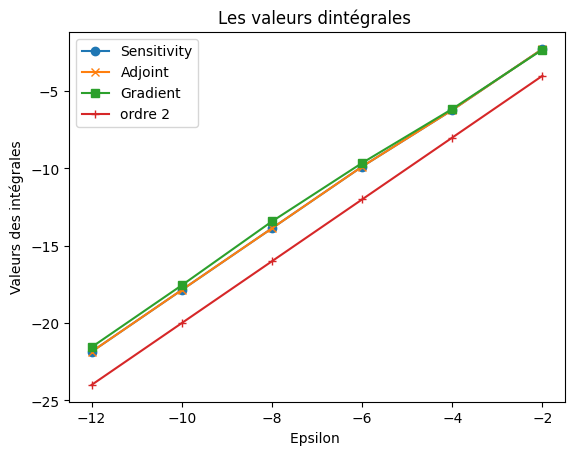

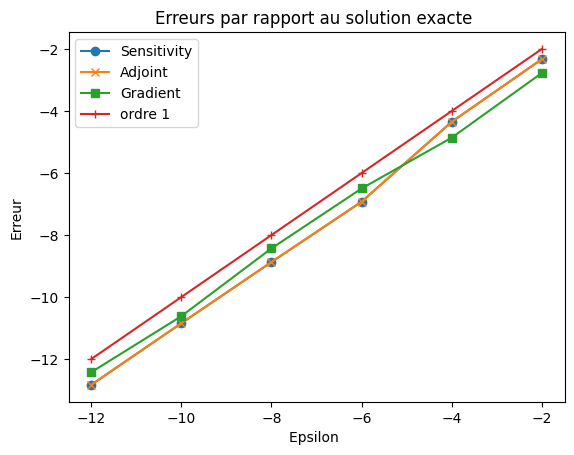

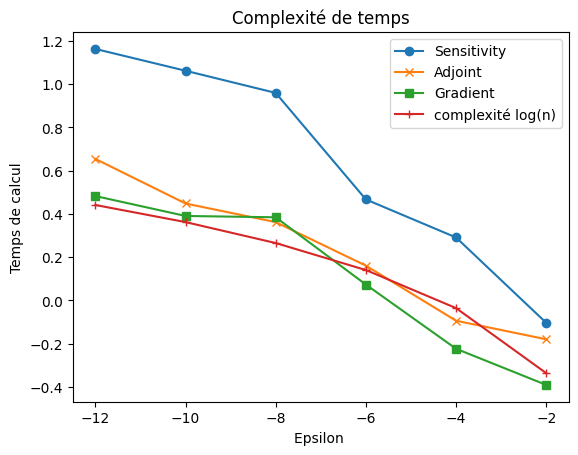

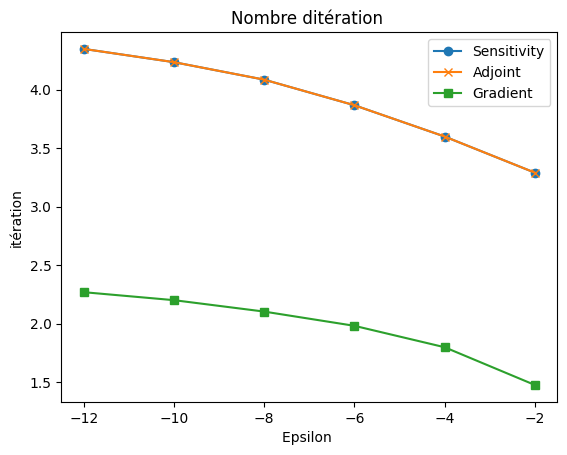

In [104]:
# Tracé avec échelle logarithmique sur l'axe des x
plt.plot(np.log10(epsilon[1:]), np.log10(eps_int_sens[1:]), label='Sensitivity', marker='o')
plt.plot(np.log10(epsilon[1:]), np.log10(eps_int_adj[1:]), label='Adjoint', marker='x')
plt.plot(np.log10(epsilon[1:]), np.log10(eps_int_grad[1:]), label='Gradient', marker='s')
plt.plot(np.log10(epsilon[1:]),2* np.log10(epsilon[1:]), label='ordre 2', marker='+')

# Ajouter une légende
plt.legend()

# Ajouter des titres et des labels
plt.title('Les valeurs d''intégrales ')
plt.xlabel('Epsilon ')
plt.ylabel('Valeurs des intégrales')


# Afficher le graphique
plt.show()

# Tracé avec échelle logarithmique sur l'axe des x
plt.plot(np.log10(epsilon[1:]), np.log10(eps_er_sens[1:]), label='Sensitivity', marker='o')
plt.plot(np.log10(epsilon[1:]), np.log10(eps_er_adj[1:]), label='Adjoint', marker='x')
plt.plot(np.log10(epsilon[1:]), np.log10(eps_er_grad[1:]), label='Gradient', marker='s')
plt.plot(np.log10(epsilon[1:]), np.log10(epsilon[1:]), label='ordre 1', marker='+')

# Ajouter une légende
plt.legend()

# Ajouter des titres et des labels
plt.title('Erreurs par rapport au solution exacte ')
plt.xlabel('Epsilon ')
plt.ylabel('Erreur')


# Afficher le graphique
plt.show()


# Tracé avec échelle logarithmique sur l'axe des x
plt.plot(np.log10(epsilon[1:]), np.log10(eps_t_sens[1:]), label='Sensitivity', marker='o')
plt.plot(np.log10(epsilon[1:]), np.log10(eps_t_adj[1:]), label='Adjoint', marker='x')
plt.plot(np.log10(epsilon[1:]), np.log10(eps_t_grad[1:]), label='Gradient', marker='s')
plt.plot(np.log10(epsilon[1:]), np.log10(0.1*np.log(1/np.array(epsilon[1:]))), label='complexité log(n)', marker='+')

# Ajouter une légende
plt.legend()

# Ajouter des titres et des labels
plt.title('Complexité de temps')
plt.xlabel('Epsilon ')
plt.ylabel('Temps de calcul')


# Afficher le graphique
plt.show()

# Tracé avec échelle logarithmique sur l'axe des x
plt.plot(np.log10(epsilon[1:]), np.log10(eps_it_sens[1:]), label='Sensitivity', marker='o')
plt.plot(np.log10(epsilon[1:]), np.log10(eps_it_adj[1:]), label='Adjoint', marker='x')
plt.plot(np.log10(epsilon[1:]), np.log10(eps_it_grad[1:]), label='Gradient', marker='s')

# Ajouter une légende
plt.legend()

# Ajouter des titres et des labels
plt.title('Nombre d''itération ')
plt.xlabel('Epsilon ')
plt.ylabel('itération')


# Afficher le graphique
plt.show()


In [130]:
print(epsilon)
eps_int_sens  
formatted_1 = [f"{val:.3e}" for val in eps_int_sens]
eps_er_sens
formatted_2 = [f"{val:.3e}" for val in eps_er_sens]
eps_t_sens
formatted_3 = [f"{val:.3e}" for val in eps_t_sens]
eps_it_sens
formatted_4 = [f"{val:.3e}" for val in eps_it_sens]

print(formatted_4)

eps_int_grad
formatted_11 = [f"{val:.3e}" for val in eps_int_grad]
eps_er_grad
formatted_22 = [f"{val:.3e}" for val in eps_er_grad]
eps_t_grad
formatted_33 = [f"{val:.3e}" for val in eps_t_grad]
eps_it_grad
formatted_44 = [f"{val:.3e}" for val in eps_it_grad]

print(formatted_33
     )

[1, 0.01, 0.0001, 1e-06, 1e-08, 1e-10, 1e-12]
['8.000e+00', '1.956e+03', '3.981e+03', '7.367e+03', '1.219e+04', '1.719e+04', '2.231e+04']
['3.100e-05', '4.062e-01', '5.972e-01', '1.184e+00', '2.423e+00', '2.458e+00', '3.039e+00']


In [95]:
# test de convergence par rapport au dx, dy
int_sens =[] ; int_adj =[]; int_grad =[]
er_sens =[] ; er_adj =[]; er_grad =[]
it_sens =[] ; it_adj =[]; it_grad =[]
t_sens =[] ; t_adj =[]; t_grad =[]
pas_dx = []
eps = 10**(-4)

for k in range(1,6):
    eps = 10**(-2*k)
    i = 2*k
    q = 3*i-1
    p = 4*i-1
    n = 2*(q+1)-1
    m = q-1
    Longeur = 6
    Hauteur = 4
    dx = Longeur/(n+1)
    dy = Hauteur/(m+1)
    x= np.linspace(0,Longeur,n+2)
    y= np.linspace(0,Hauteur,m+2)
    x1 = np.linspace(0,4,p+2)
    x2 = np.linspace(3,6,q+2)
    Xu, Yu = np.meshgrid(x1[1:-1], y[1:-1])
    Xv, Yv = np.meshgrid(x2[1:-1], y[1:-1])

    Fu = f(Xu,Yu)
    Fv = f(Xv,Yv)
    fu = Fu.ravel(order='C')
    fv = Fv.ravel(order='C')
    
    Mu, Mv= mat_Mu_Mv(p,q,m,dx,dy)
    Mu_fact = lu_factor(Mu)
    Mv_fact = lu_factor(Mv)
    Mu_inv = np.linalg.inv(Mu)
    Mv_inv = np.linalg.inv(Mv)
    R, S = mat_R_S(p,q,n)
    A, B = mat_A_B(p,q,n,m,dx,dy,Mu,Mv,R,S)
    g_initial = np.random.rand(m)
    h_initial = np.random.rand(m)
    pas_dx.append(n)
    if k<6 : 
        integral_sens, err_sens, iter_sens, time_sens , test_sens= sensibilite(p,q,m,n,g_initial,h_initial,Mu,Mv,eps,5)
        integral_adj, err_adj, iter_adj, time_adj , test_adj = adjointe(p,q,m,n,g_initial,h_initial,Mu,Mv,eps,5)
        integral_grad, err_grad, iter_grad, time_grad = gradient_projete(p,q,m,n,A,B,eps,g_initial,h_initial)
    
        int_sens.append(integral_sens) ; int_adj.append(integral_adj); int_grad.append(integral_grad)
        er_sens.append(err_sens) ;er_adj.append(err_adj); er_grad.append(err_grad*2)
        it_sens.append(iter_sens) ; it_adj.append(iter_adj); it_grad.append(iter_grad)
        t_sens.append(time_sens) ;t_adj.append(time_adj); t_grad.append(time_grad)
    else :
#        integral_sens, err_sens, iter_sens, time_sens , test_sens= sensibilite(p,q,m,n,g_initial,h_initial,Mu,Mv,eps,5)
        integral_adj, err_adj, iter_adj, time_adj , test_adj = adjointe(p,q,m,n,g_initial,h_initial,Mu,Mv,eps,5)
        integral_grad, err_grad, iter_grad, time_grad = gradient_projete(p,q,m,n,A,B,eps,g_initial,h_initial)
    
        int_sens.append(integral_adj) ; int_adj.append(integral_adj); int_grad.append(integral_grad)
        er_sens.append(err_adj) ;er_adj.append(err_adj); er_grad.append(err_grad*2)
        it_sens.append(iter_adj) ; it_adj.append(iter_adj); it_grad.append(iter_grad)
#        t_sens.append(time_adj*time_sens[-1]/time_sens[-2]) ;
        t_adj.append(time_adj); t_grad.append(time_grad)
        
n_int_sens =int_sens
n_int_adj =int_adj
n_int_grad =int_grad

n_t_sens = t_sens
n_t_adj = t_adj
n_t_grad = t_grad

n_it_sens = it_sens
n_it_adj = it_adj
n_it_grad = it_grad

n_er_sens = er_sens
n_er_adj = er_adj
n_er_grad = er_grad

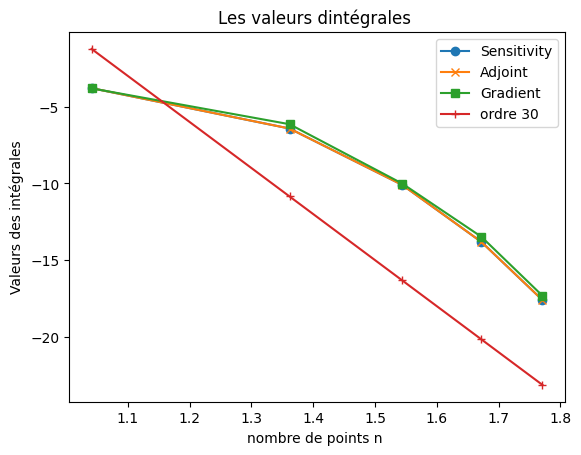

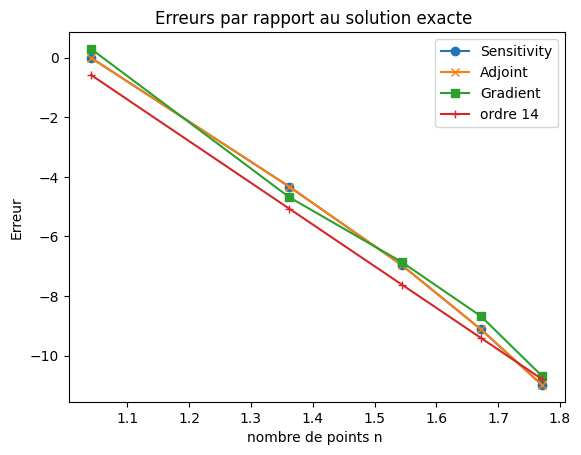

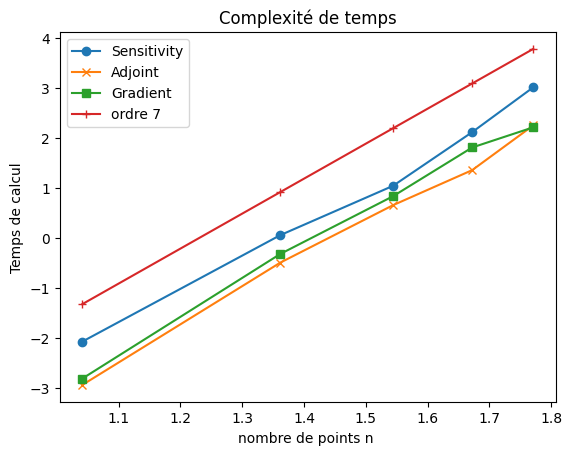

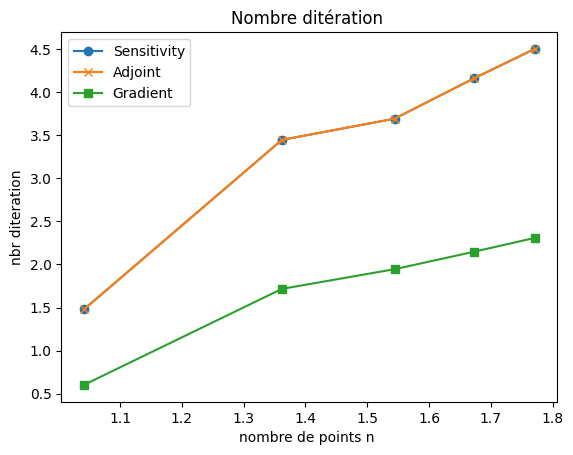

In [154]:
# Tracé avec échelle logarithmique sur l'axe des x
plt.plot(np.log10(pas_dx), np.log10(n_int_sens), label='Sensitivity', marker='o')
plt.plot(np.log10(pas_dx), np.log10(n_int_adj), label='Adjoint', marker='x')
plt.plot(np.log10(pas_dx), np.log10(n_int_grad), label='Gradient', marker='s')
plt.plot(np.log10(pas_dx), -30*np.log10(np.array(pas_dx)/10**(1)), label='ordre 30', marker='+')

# Ajouter une légende
plt.legend()

# Ajouter des titres et des labels
plt.title('Les valeurs d''intégrales ')
plt.xlabel('nombre de points n ')
plt.ylabel('Valeurs des intégrales')


# Afficher le graphique
plt.show()

# Tracé avec échelle logarithmique sur l'axe des x
plt.plot(np.log10(pas_dx), np.log10(n_er_sens), label='Sensitivity', marker='o')
plt.plot(np.log10(pas_dx), np.log10(n_er_adj), label='Adjoint', marker='x')
plt.plot(np.log10(pas_dx), np.log10(n_er_grad), label='Gradient', marker='s')
plt.plot(np.log10(pas_dx), -14*np.log10(np.array(pas_dx)/10**(1)), label='ordre 14', marker='+')

# Ajouter une légende
plt.legend()

# Ajouter des titres et des labels
plt.title('Erreurs par rapport au solution exacte ')
plt.xlabel('nombre de points n ')
plt.ylabel('Erreur')


# Afficher le graphique
plt.show()


# Tracé avec échelle logarithmique sur l'axe des x
plt.plot(np.log10(pas_dx), np.log10(n_t_sens), label='Sensitivity', marker='o')
plt.plot(np.log10(pas_dx), np.log10(n_t_adj), label='Adjoint', marker='x')
plt.plot(np.log10(pas_dx), np.log10(n_t_grad), label='Gradient', marker='s')
plt.plot(np.log10(pas_dx), 7*np.log10(np.array(pas_dx)/17**(1)), label='ordre 7', marker='+')

# Ajouter une légende
plt.legend()

# Ajouter des titres et des labels
plt.title('Complexité de temps')
plt.xlabel('nombre de points n ')
plt.ylabel('Temps de calcul')


# Afficher le graphique
plt.show()

# Tracé avec échelle logarithmique sur l'axe des x
plt.plot(np.log10(pas_dx), np.log10(n_it_sens), label='Sensitivity', marker='o')
plt.plot(np.log10(pas_dx), np.log10(n_it_adj), label='Adjoint', marker='x')
plt.plot(np.log10(pas_dx), np.log10(n_it_grad), label='Gradient', marker='s')

# Ajouter une légende
plt.legend()

# Ajouter des titres et des labels
plt.title('Nombre d''itération ')
plt.xlabel('nombre de points n ')
plt.ylabel('nbr d''iteration')


# Afficher le graphique
plt.show()


In [123]:
print(pas_dx)
n_int_sens
formatted_1 = [f"{val:.3e}" for val in n_int_sens]
n_er_sens
formatted_2 = [f"{val:.3e}" for val in n_er_sens]
n_t_adj
formatted_3 = [f"{val:.3e}" for val in n_t_adj]
n_it_sens
formatted_4 = [f"{val:.3e}" for val in n_it_sens]

print(formatted_3)

n_int_grad
formatted_11 = [f"{val:.3e}" for val in n_int_grad]
n_er_grad
formatted_22 = [f"{val:.3e}" for val in n_er_grad]
n_t_grad
formatted_33 = [f"{val:.3e}" for val in n_t_grad]
n_it_grad
formatted_44 = [f"{val:.3e}" for val in n_it_grad]

print(n_it_grad
     )

[11, 23, 35, 47, 59]
['1.148e-03', '3.218e-01', '4.533e+00', '2.279e+01', '1.787e+02']
[4, 52, 88, 140, 203]


# méthode d'Uzawa
l'algo est comme la suivante:
1) on choisit $\lambda \in \mathbb{R}^{m*(p+q)}$
2) on calcule $X^n$ grâce à 
$$ \nabla_X L = \nabla_Xf(X^n) - B^T \lambda^n = 0 $$
avec $$ f(X^n) = (X^n)^T A X^n $$
3) on calcule $$g^n=BX^n -C$$
4) test $$\| BX^n -C \|< \epsilon$$ si oui, alors on a la convergence
5) sinon, $$\lambda^{n+1} = \lambda^n - \mu*g^n$$ et on reprends l'étape 2

### Vérification pour le pseudo-inverse

### 1) Vérification des matrice de Cours

In [153]:
# vérisication de cours
A_cours = np.eye(3)
A_cours[2,2] = 0

B_cours = np.array([[1, 2, -1],  # Chaque ligne doit être une liste
                    [1, 1,  1]])
C_cours = np.array([0,1])
xi_cours = np.array([1,4,0])
Xn_cours = np.array([-1,1,1])
AXnxi =  A_cours @ Xn_cours - xi_cours
#print( AXnxi)

lam_cours = solve(B_cours@B_cours.T,B_cours@(AXnxi))
#print(A_cours@Xn_cours-xi_cours-B_cours.T@lam_cours)

# vérification 
#print( A_cours@Xn_cours - xi_cours -B_cours.T@lam_cours)
espilon = 10**(-10)
AA_cours = A_cours.T@A_cours +epsilon*np.eye(3) 
X_test_cours = solve(AA_cours, A_cours.T@(xi_cours+B_cours.T@lam_cours))

print('lambda =',lam_cours)
print('X test = ',X_test_cours)
print('X cours = ',Xn_cours)

lambda = [-1. -1.]
X test =  [-1.e-10  1.e-10  0.e+00]
X cours =  [-1  1  1]


### 2) Vérification pour notre matrice pour la méthode d'Uzawa

In [155]:
# vérification pour uzawa
g0 = np.random.rand(m)
h0 = np.random.rand(m)
Un = solve(Mu,bu(g0,p,q,m,fu))
Vn = solve(Mv,bv(h0,p,q,m,fv))
Xn = np.concatenate([Un, Vn, g0, h0])

# vérification qu'on a le bon C, Xn c'est la solution obtenue par la méthode Gradient projeté
C = np.concatenate([fu,fv])
gn = np.matmul(B,Xn)-C
#print(np.linalg.norm(gn))

epsilon=10**(-10)
lamd_uzawa = np.linalg.inv(B@B.T)@B@A@Xn
X_test, residus, rang, s = lstsq(A,B.T@lamd_uzawa)
gn = np.matmul(B,X_test)-C
print('norme( BX-C ) = ',np.linalg.norm(gn))
print('X_0 - X_test = ',Xn[11:16]-X_test[11:16])
print('------')
mu=0.5
lamd_uzawa = lamd_uzawa + mu * gn 
X_test = np.linalg.inv(A.T@A + epsilon*np.eye(A.shape[1]))@A.T@B.T@lamd_uzawa
gn = np.matmul(B,X_test)-C
print(np.linalg.norm(gn))
print('X_0 - X_test = ',Xn[11:16]-X_test[11:16])

norme( BX-C ) =  844.1353134916457
X_0 - X_test =  [7.67110916 4.84346284 4.88662103 4.36783643 3.11990753]
------
5190332.385846866
X_0 - X_test =  [ 7.67110916e+00 -1.28098399e+04  8.25435999e+02  1.04690759e+04
  3.11990753e+00]


In [49]:
# 1) choix de lambda
lamb = np.random.rand(m*(p+q))
mu = 0.05
# Paramètre de régularisation
epsilon = 10**(10)
print(np.linalg.matrix_rank(A))
# Construire la matrice pour la régularisation
ATA = 2 * (A.T @ A) + epsilon * np.eye(A.shape[1])
ATBT_lambda = A.T @ (B.T @ lamb)

# Résolution du système régularisé
ATA_fact = cho_factor(ATA)
Xn = cho_solve(ATA_fact, ATBT_lambda)


# 3 calcule de g^n
gn = np.matmul(B,Xn)-C
print(np.linalg.norm(gn))
while np.linalg.norm(gn)>epsi :
    lamb = lamb - mu * gn  
    ATBT_lambda = A.T @ (B.T @ lamb)
    Xn = cho_solve(ATA_fact, ATBT_lambda)
    gn = np.matmul(B,Xn)-C
   # print(np.linalg.norm(gn))


60
442.40536586194963


KeyboardInterrupt: 